In [33]:
using Revise
using FinalProject
using Plots

## Load the data

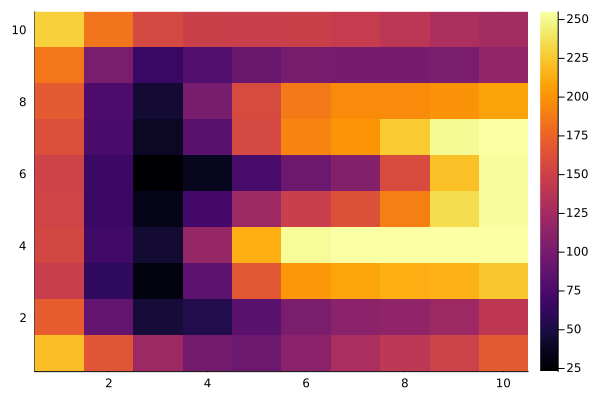

In [34]:
labels, images = get_data("../data/data_alphabet.npz")
r = images[:,:,labels .== 0x04]
Plots.heatmap(reverse(r[:,:,6], dims=1))

## Chose two letters & create train and test sets

(3, 30)


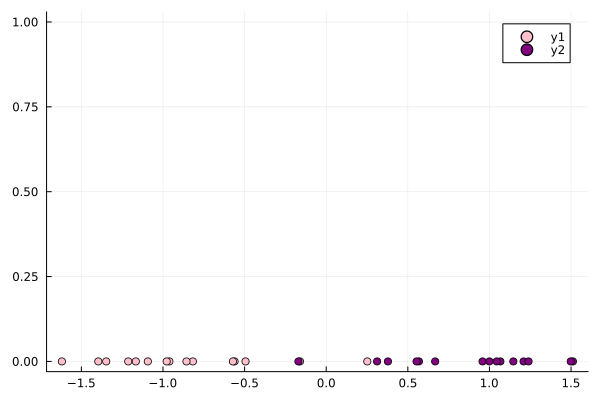

In [618]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V',
'Y', 'Z']
# CN, CZ;
# JL, EB - test set also separable
imgs, lbls, letter_counts = create_work_set(alphabet, images, labels, letters = "CZ");
imgs_trn, lbls_trn, imgs_tst, lbls_tst = crossval(imgs, lbls, letter_counts);

# Create image features
method1 = LeftRight()
method2 = TopBottom()
x_trn = compute_measurements(imgs_trn, meas_type = method1)
y_trn = compute_measurements(imgs_trn, meas_type = method2)
x_tst = compute_measurements(imgs_tst, meas_type = method1)
y_tst = compute_measurements(imgs_tst, meas_type = method2)

# Create matrices of all the measurments
X_trn_2 = vcat(x_trn',y_trn')
X_trn_1 = reshape(x_trn, 1, size(x_trn)[1])
X_tst_2 = vcat(x_tst',y_tst')
X_tst_1 = reshape(x_tst, 1, size(x_tst)[1])

# Prepare the data
X_trn_1 = add_padding(X_trn_1, position="under")
X_trn_2 = add_padding(X_trn_2)
lbls_trn = flip_lbls(lbls_trn)
X_tst_1 = add_padding(X_tst_1, position="under")
X_tst_2 = add_padding(X_tst_2)
lbls_tst = flip_lbls(lbls_tst)

println(size(X_trn_2))

# Show training data separability
x1 = x_tst[1:size(x_trn)[1]÷2]
x2 = x_tst[size(x_trn)[1]÷2+1:end]
plot(x1,zeros(15),seriestype=:scatter, color=:pink)
plot!(x2,zeros(15),seriestype=:scatter, color=:purple)

## Logistic regression

In [607]:
# Compute logistic loss and its gradient
X = [1 1 1 ; 1 2 3]
l = [1, -1, -1]
w = [1.5, -0.5]
println(logistic_loss(X,l,w))
logistic_loss_gradient(X,l,w)

0.6601619507527583


2×1 Matrix{Float64}:
 0.28450596994395316
 0.8253257470112381

Find the weights w with gradient descent and classify

In [619]:
w_init = [-4.0,-1.0]
res = logistic_loss(X_trn_1,lbls_trn,w_init)
w,wt,Et = logistic_loss_gradient_descent(X_trn_1,lbls_trn,w_init)
res_lbl = classification(X_tst_1, w, "logreg")
err = compute_error(res_lbl, lbls_tst)
println("Classification error on the test set: $(err)")

Classification error on the test set: 0.06666666666666667


Classify using 2 features

In [620]:
w_init = [-7.0,2.0,-8.0]
res = logistic_loss(X_trn_2,lbls_trn,w_init)
w,wt,Et = logistic_loss_gradient_descent(X_trn_2,lbls_trn,w_init)
res_lbl = classification(X_tst_2, w, "logreg")
err = compute_error(res_lbl, lbls_tst)
println("Classification error on the test set: $(err)")

Classification error on the test set: 0.06666666666666667


Plot the progress of the gradient descent

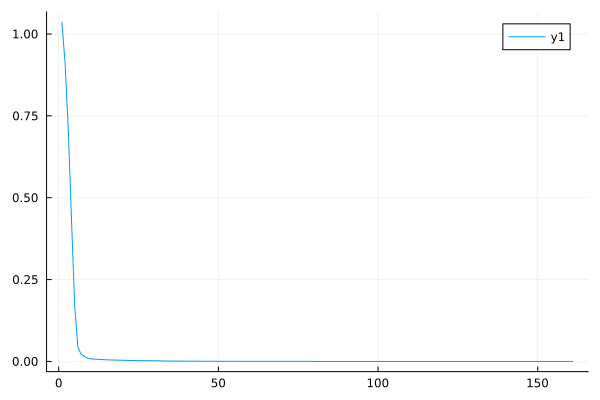

In [599]:
xs = 1:size(Et)[1]
plot(xs,Et)

Show test data separation

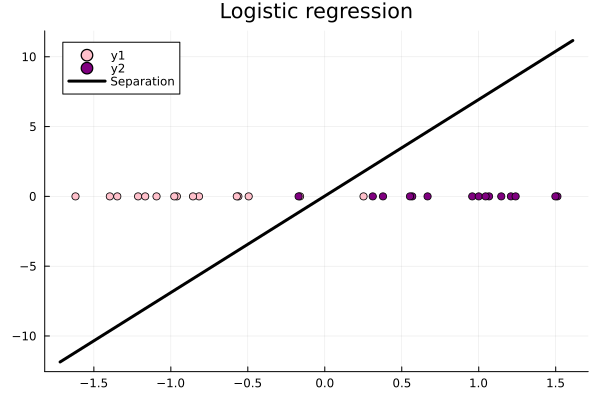

In [621]:
create_plot(x_tst, w, 3, "Logistic regression")

## Kozinec algorithm

In [622]:
# Arbitrary data
X = [3 4 5 -1 -1.5 -3 ; 1 0 1 -2 -1 -1.5]
y = [1,1,1,0,0,0]
X_n = add_padding(X)
y_n = flip_lbls(y)
alpha_k = kozinec(X_n,y_n)
alpha_p = kozinec(X_n,y_n,alg = Perceptron())
println(alpha_k)
println(alpha_p)

[3.0, 1.0, 1.0]
[3.0, 1.0, 1.0]


Classify test data

In [623]:
alpha_k = kozinec(X_trn_1, lbls_trn)
res_koz = classification(X_tst_1, alpha_k,"kozinec")
alpha_p = kozinec(X_trn_1, lbls_trn, alg=Perceptron())
res_per = classification(X_tst_1, alpha_k,"kozinec")
err_k = compute_error(res_koz, lbls_tst)
err_p = compute_error(res_per, lbls_tst)
println(alpha_k)
println(alpha_p)
println("Kozinec algorithm classification error on test data: $(err_k)")
println("Perceptron algorithm classification error on test data: $(err_p)")

[-0.3480046924691331, -0.00588747586081842]
[-1.5777404650120155, 0.0]
Kozinec algorithm classification error on test data: 0.06666666666666667
Perceptron algorithm classification error on test data: 0.06666666666666667


Classify test data using 2 features

In [624]:
alpha_k = kozinec(X_trn_2, lbls_trn)
res_koz = classification(X_tst_2, alpha_k,"kozinec")
alpha_p = kozinec(X_trn_2, lbls_trn, alg=Perceptron())
res_per = classification(X_tst_2, alpha_k,"kozinec")
err_k = compute_error(res_koz, lbls_tst)
err_p = compute_error(res_per, lbls_tst)
println(alpha_k)
println(alpha_p)
println("Kozinec algorithm classification error on test data: $(err_k)")
println("Perceptron algorithm classification error on test data: $(err_p)")

[-0.47031928847662613, 0.040370430155753506, -0.067684410446361]
[-2.694669507864134, 0.5706381518113336, 0.0]
Kozinec algorithm classification error on test data: 0.03333333333333333
Perceptron algorithm classification error on test data: 0.03333333333333333


Show test data separation

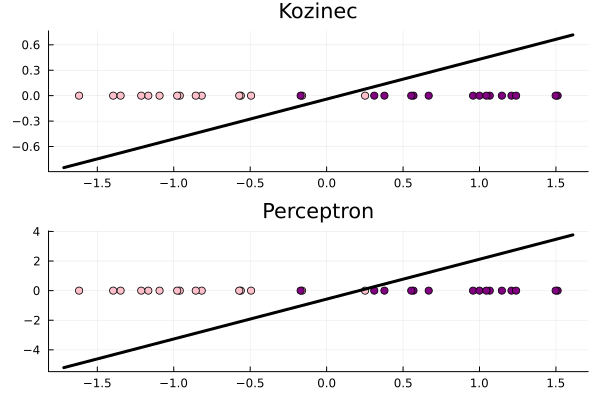

In [625]:
p1 = create_plot(x_tst, alpha_k,2, "Kozinec")
p2 = create_plot(x_tst, alpha_p,2, "Perceptron")
plot(p1, p2,layout=(2,1), legend=false)

## Inseparable data

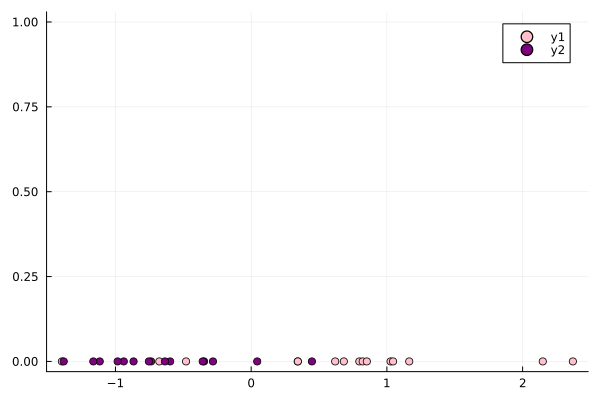

In [766]:
#AC, MN, KP, YT
# Best: DH, YT
imgs, lbls, letter_counts = create_work_set(alphabet, images, labels, letters = "AC");
imgs_trn, lbls_trn, imgs_tst, lbls_tst = crossval(imgs, lbls, letter_counts);

x_trn = compute_measurements(imgs_trn, meas_type = method1)
y_trn = compute_measurements(imgs_trn, meas_type = method2)
x_tst = compute_measurements(imgs_tst, meas_type = method1)
y_tst = compute_measurements(imgs_tst, meas_type = method2)

# Create matrices of all the measurments
X_trn_2 = vcat(x_trn',y_trn')
X_trn_1 = reshape(x_trn, 1, size(x_trn)[1])
X_tst_2 = vcat(x_tst',y_tst')
X_tst_1 = reshape(x_tst, 1, size(x_tst)[1])

# Prepare the data
X_trn_1 = add_padding(X_trn_1, position="under")
X_trn_2 = add_padding(X_trn_2)
lbls_trn = flip_lbls(lbls_trn)
X_tst_1 = add_padding(X_tst_1, position="under")
X_tst_2 = add_padding(X_tst_2)
lbls_tst = flip_lbls(lbls_tst)


# Show data inseparability
x1 = x_tst[1:size(x_trn)[1]÷2]
x2 = x_tst[size(x_trn)[1]÷2+1:end]
plot(x1,zeros(15),seriestype=:scatter, color=:pink)
plot!(x2,zeros(15),seriestype=:scatter, color=:purple)

In [767]:
# Logreg
w_init = [-4.0,-1.0]
res = logistic_loss(X_trn_1,lbls_trn,w_init)
w,wt,Et = logistic_loss_gradient_descent(X_trn_1,lbls_trn,w_init)
res_lbl = classification(X_trn_1, w, "logreg")
err = compute_error(res_lbl, lbls_trn)
# println(lbls_trn)
# println(res_lbl)
println("Classification error on the train set: $(err)")

Classification error on the train set: 0.13333333333333333


In [759]:
# Kozinec
alpha_k = kozinec(X_trn_1, lbls_trn)
res_koz = classification(X_trn_1, alpha_k,"kozinec")
alpha_p = kozinec(X_trn_1, lbls_trn, alg=Perceptron())
res_per = classification(X_tst_1, alpha_k,"kozinec")
err_k = compute_error(res_koz, lbls_trn)
err_p = compute_error(res_per, lbls_tst)


ErrorException: Not enough iterations. The data might be inseparable.

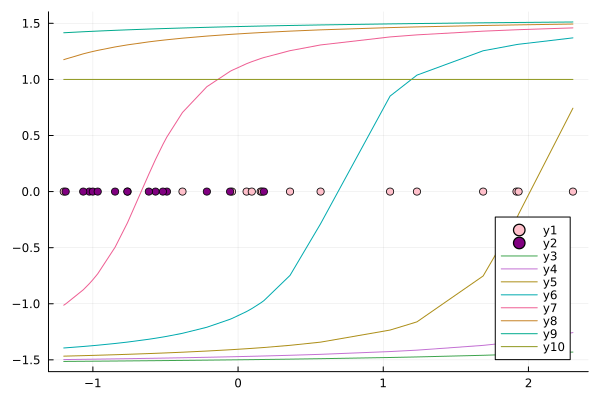

In [768]:
dims=7
m2 = Arctan()
a = collect(dimension_lifting(x_trn, dims=dims, lifter = m2))
a = reduce(vcat,transpose.(a))
b = collect(dimension_lifting(x_tst,dims=dims, lifter = m2))
b = reduce(vcat,transpose.(b))
x1 = x_trn[1:size(x_trn)[1]÷2]
x2 = x_trn[size(x_trn)[1]÷2+1:end]
p1 = plot(x1,zeros(15),seriestype=:scatter, color=:pink)
p1 = plot(p1, x2,zeros(15),seriestype=:scatter, color=:purple)
indices = sortperm(x_trn)
x_n = x_trn[indices]
p1 = plot(p1,x_n,a[:,1:end])

Classification error on the train set: 0.03333333333333333


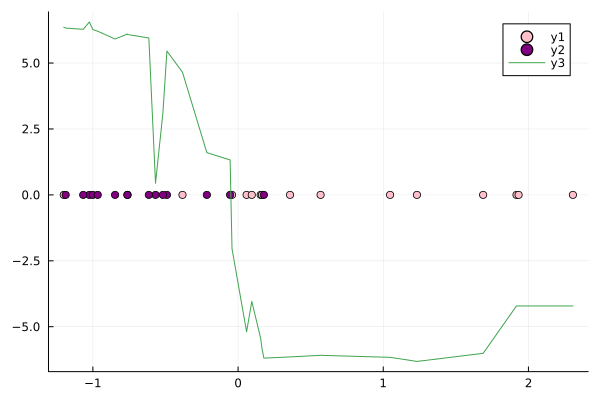

In [769]:
w_init = ones(dims+1)
a = reshape(a,dims+1,30)
b = reshape(b,dims+1,30)
res = logistic_loss(a,lbls_trn,w_init)
w,wt,Et = logistic_loss_gradient_descent(a,lbls_trn,w_init)
res_lbl = classification(a, w, "logreg")
err = compute_error(res_lbl, lbls_trn)
println("Classification error on the train set: $(err)")
res = a'*w
x1 = x_trn[1:size(x_trn)[1]÷2]
x2 = x_trn[size(x_trn)[1]÷2+1:end]
p2 = plot(x1,zeros(15),seriestype=:scatter, color=:pink)
p2 = plot(p2, x2,zeros(15),seriestype=:scatter, color=:purple)
indices = sortperm(x_trn)
x_n = x_trn[indices]
p2 = plot(p2,x_n,res)

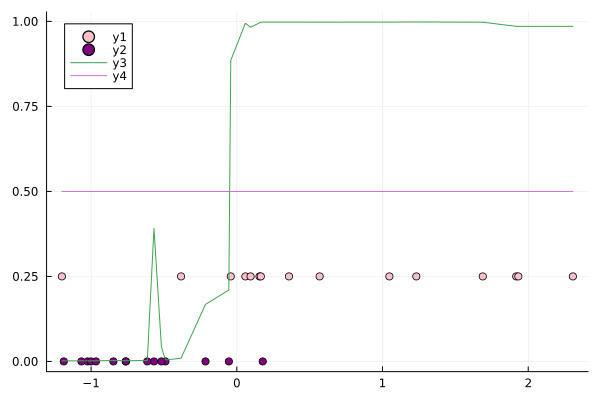

In [773]:
x1 = x_trn[1:size(x_trn)[1]÷2]
x2 = x_trn[size(x_trn)[1]÷2+1:end]
p3 = plot(x1,zeros(15).+0.25,seriestype=:scatter, color=:pink)
p3 = plot(p3, x2,zeros(15),seriestype=:scatter, color=:purple)
indices = sortperm(x_trn)
x_n = x_trn[indices]
post = posteriori(res)
post2 = posteriori(-res)
p3 = plot(p3,x_n,post)
# p3 = plot(p3,x_n,post2)
p3 = plot(p3,x_n,ones(size(post)[1]).*0.5)

In [771]:
lbls_post = [ifelse(el >= 0.5, -1, 1) for el in post]
println(lbls_post)
println(lbls_trn)
err = compute_error(lbls_post, lbls_trn)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


0.03333333333333333